In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
df = pd.read_excel('data.xlsx')
df['Data'] = pd.to_datetime(df['Data'], infer_datetime_format = True)
indexedDf = df.set_index(['Data'])

In [3]:
indexedDf

,US$
Data,
2010-01-04,133.90
2010-01-05,134.69
2010-01-06,132.25
2010-01-07,130.00
2010-01-08,133.52
...,...
2020-05-28,2401.10
2020-05-29,2442.37
2020-06-01,2471.04


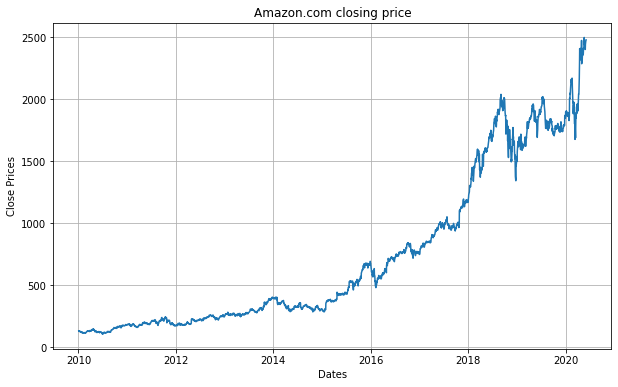

In [4]:
#Plot close price
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(indexedDf)
plt.title("Amazon.com closing price")
plt.show()

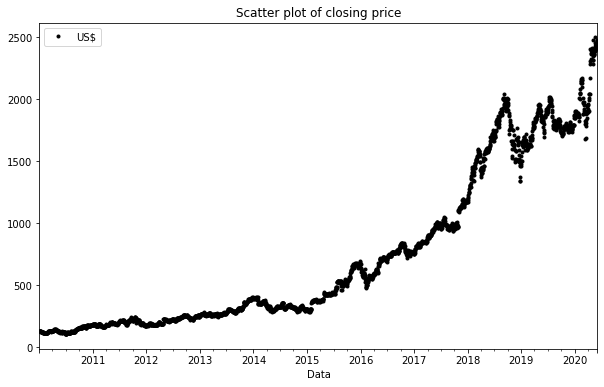

In [5]:
#Scatterplot:
indexedDf.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

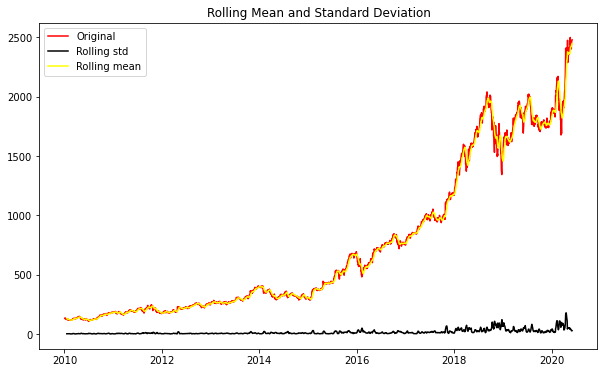

Results of Dickey Fuller Test
Test Statistics                   1.902445
P-Value                           0.998532
No. of lags used                 23.000000
Number of observations used    2694.000000
Critical Value(1%)               -3.432780
Critical Value(5%)               -2.862613
Critical Value(10%)              -2.567341
dtype: float64


In [6]:
#Test for stationarity

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std();
    #Plot rolling statistics:
    plt.plot(timeseries, color = 'red', label ='Original')
    plt.plot(rolstd, color = 'black', label = 'Rolling std')
    plt.plot(rolmean, color = 'yellow', label = 'Rolling mean')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of Dickey Fuller Test")
    adft = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(adft[0:4], index = ['Test Statistics', 'P-Value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['Critical Value(%s)'%key] = values
    print(output)
    
test_stationarity(indexedDf)

<Figure size 720x432 with 0 Axes>

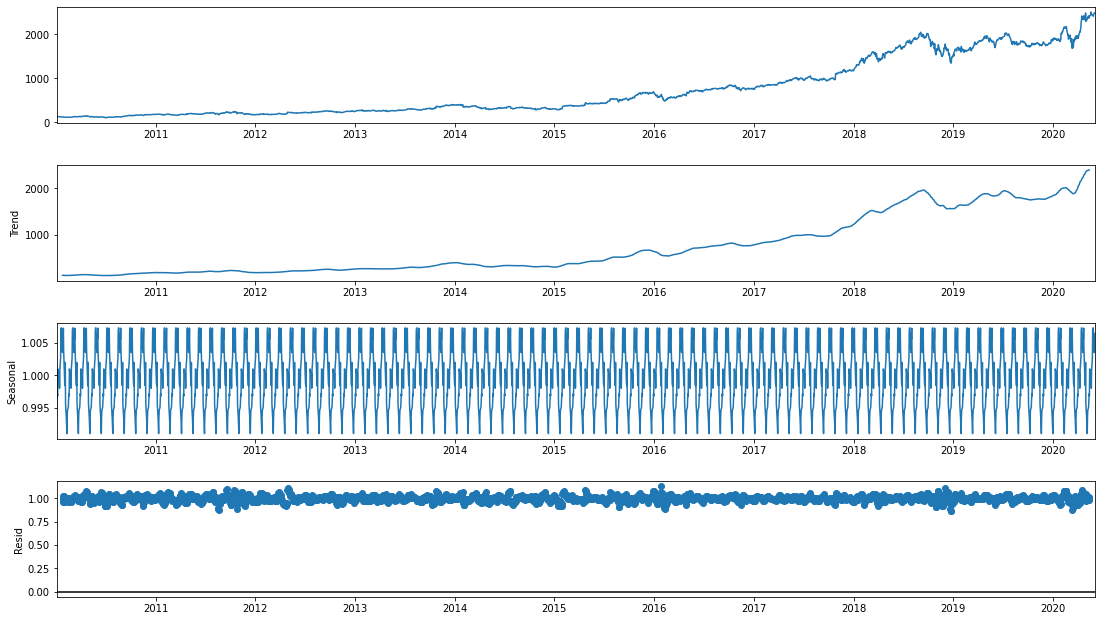

In [7]:
#P-value is greater than 0.05 so we cannot reject the Null hypothesis, also 1.902445 (Test Statistics) 
# is greater than the critical values (-3.432780 (1%), -2.862613(5%), -2.567341(10%), so the data is non-stationary.
#The data will become stationary after we separate seasonality and trend from our series.
#"The multiplicative model is useful when the seasonal variation increases over time."

result = seasonal_decompose(indexedDf, model = 'multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

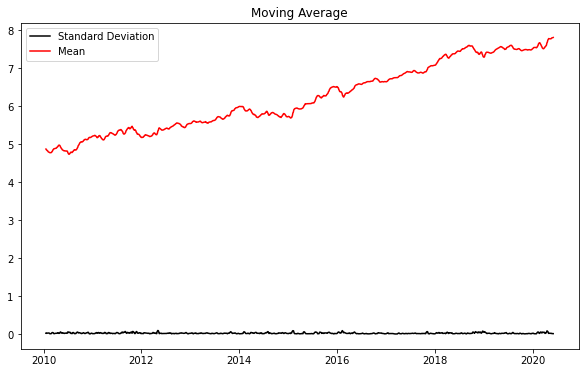

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(indexedDf)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color = "black", label = "Standard Deviation")
plt.plot(moving_avg, color = "red", label = "Mean")
plt.legend(loc = 'best')
plt.show()

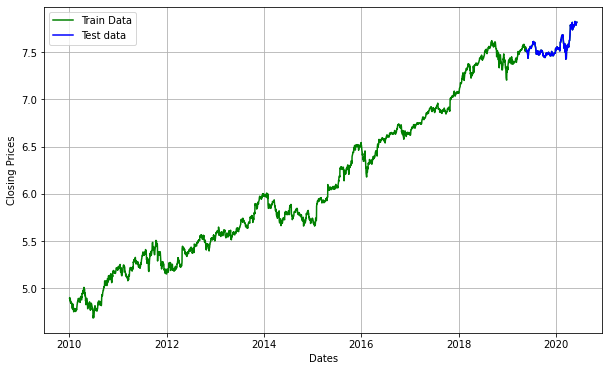

In [9]:
#We are going to create an ARIMA model 

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label = 'Train Data')
plt.plot(test_data, 'blue', label = 'Test data' )
plt.legend()

In [10]:
model_autoARIMA = auto_arima(train_data, start_p = 0, start_q = 0,
                            test = 'adf',
                            max_p = 3, max_q = 3,
                            m = 1,
                            d = None,
                            seasonal=False,
                            start_P = 0,
                            D = 0,
                            trace = True,
                            error_action = 'ignore',
                            suppres_warnings = True,
                            stepwise = True
                            )
print(model_autoARIMA.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12302.404, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12300.462, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12300.466, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12296.774, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12302.056, Time=1.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.023 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2443
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6153.202
Date:                Fri, 26 Feb 2021   AIC                         -12302.404
Time:                        17:06:01   BIC                         -12290.803
Sample:                             0   HQIC                        -12298.188
                               - 2443                             

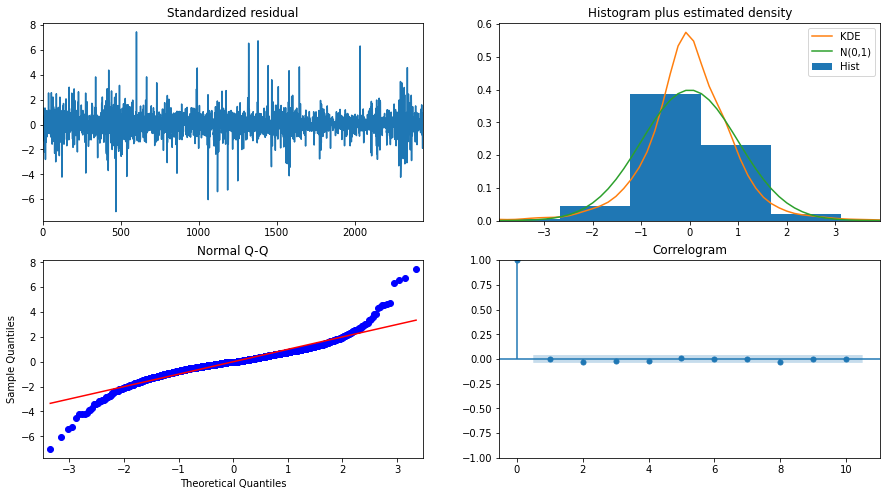

In [11]:
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()

In [12]:
import warnings
warnings.filterwarnings('ignore')
train_data.index = pd.DatetimeIndex(train_data.index.values, freq=train_data.index.inferred_freq)
model = ARIMA(train_data, order = (0, 1, 0))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.US$   No. Observations:                 2442
Model:                 ARIMA(0, 1, 0)   Log Likelihood                6153.202
Method:                           css   S.D. of innovations              0.019
Date:                Fri, 26 Feb 2021   AIC                         -12302.404
Time:                        17:06:04   BIC                         -12290.803
Sample:                    01-08-2010   HQIC                        -12298.188
                         - 05-20-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.764      0.006       0.000       0.002


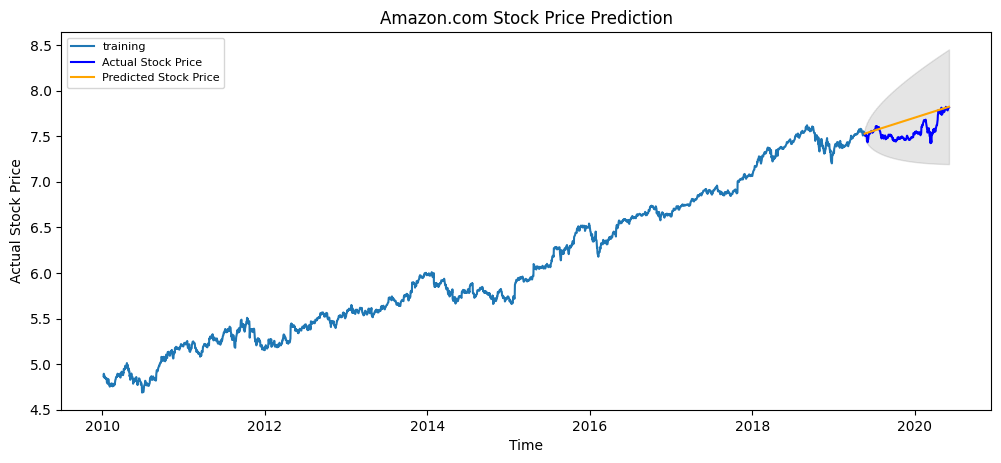

In [13]:
fc, se, conf = fitted.forecast(272, alpha = 0.05)
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index = test_data.index)
plt.figure(figsize=(12, 5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, color = 'blue', label = 'Actual Stock Price')
plt.plot(fc_series, color = 'orange', label = 'Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha=.10)
plt.title('Amazon.com Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc ='upper left', fontsize = 8)
plt.show()

In [14]:
fc=fc.reshape(272,1)
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 0.020337023302202915
MAE: 0.11903168185983837
RMSE: 0.14260793562141946
MAPE: US$    0.01583
dtype: float64


In [ ]:
#1.5% MAPE (Mean Absolute Percentage Error). The model is about 98.5% accurate in predicting the test set observations.

In [15]:
fc


Data
2019-05-21    7.528867
2019-05-22    7.529957
2019-05-23    7.531046
2019-05-24    7.532135
2019-05-27    7.533225
                ...   
2020-05-28    7.819729
2020-05-29    7.820818
2020-06-01    7.821908
2020-06-02    7.822997
2020-06-03    7.824087
Length: 272, dtype: float64